In [1]:
%matplotlib inline

In [45]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date

#import missingno 

In [3]:
pd.options.display.max_rows = 999

In [4]:
# Database connection
import mysql.connector



con = mysql.connector.connect(host=host, database=database, user=user, password=password)

#table = ‘platform_market_prices2’

data = pd.read_sql("SELECT * FROM platform_market_prices2", con=con)

con.close()

In [5]:
df = data.sort_values(by='date')
pd.to_datetime(df['date'])
df.head()

,id,source,country,market,product_cat,product_agg,product,date,retail,wholesale,currency,unit,active,udate
54889,386128,EAGC-RATIN,KEN,Nairobi,Cereals - Other,Barley,Barley,2013-05-29,46,42,KES,1Kg,1,2019-04-23 09:44:08
55710,386980,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,2013-06-17,47,33,KES,1Kg,1,2019-04-23 09:45:58
56090,387375,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,2013-06-20,47,33,KES,1Kg,1,2019-04-23 09:46:46
44955,383515,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,2013-06-24,45,33,KES,1Kg,1,2019-04-20 10:41:52
76217,413249,EAGC-RATIN,TZA,Arusha,Cereals - Rice,Rice,Morogoro Rice,2014-08-20,91,75,KES,1Kg,1,2019-07-15 06:42:57


In [6]:
len_p = len(df['product_agg'].unique())
len_m = len(df['market'].unique())
len_s = len(df['source'].unique())
print(f'Unique product, market, and source, respectively: {len_p}, {len_m}, {len_s}')
print(f'Number of combinations: {len_p*len_m*len_s}')

Unique product, market, and source, respectively: 64, 200, 8
Number of combinations: 102400


In [7]:
# construct complete time frame
date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
time_df = pd.DataFrame([], index=date_range)
time_df.tail()

""
2019-10-24
2019-10-25
2019-10-26
2019-10-27
2019-10-28


In [8]:
# check for completeness, single time series
PRODUCT = 'Rice'
MARKET = 'Gitega'
SOURCE = 'EAGC-RATIN'

subset_single = df[(df['product_agg']==PRODUCT) & (df['market']==MARKET) & (df['source']==SOURCE)].sort_values('date').set_index('date')
subset_single.head()

,id,source,country,market,product_cat,product_agg,product,retail,wholesale,currency,unit,active,udate
date,,,,,,,,,,,,,
2013-06-17,386980,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,47,33,KES,1Kg,1,2019-04-23 09:45:58
2013-06-20,387375,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,47,33,KES,1Kg,1,2019-04-23 09:46:46
2013-06-24,383515,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Unprocessed/husked rice,45,33,KES,1Kg,1,2019-04-20 10:41:52
2018-05-31,382014,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Imported Rice,167,161,KES,1Kg,1,2019-04-20 10:40:09
2018-06-07,383356,EAGC-RATIN,BDI,Gitega,Cereals - Rice,Rice,Imported Rice,172,166,KES,1Kg,1,2019-04-20 10:41:41


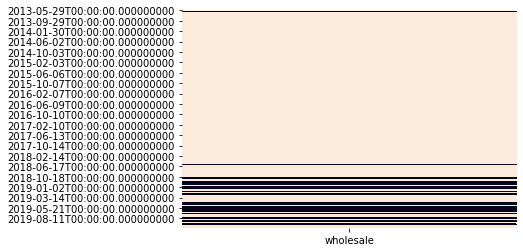

In [9]:
subset_single = time_df.merge(subset_single[['wholesale']], how='left', left_index=True, right_index=True)

new_colname = PRODUCT+'_'+MARKET+'_'+ SOURCE
new_set = subset_single.rename(columns={'wholesale':new_colname})

ax = sns.heatmap(subset_single.isnull(), cbar=False)
#ax.set_yticklabels(new_set.index.strftime('%Y/%m/%d'))
# how to change y-axis date format??
plt.show()

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(new_set, title='Profile report', explorative=True)
# pandas profile not very useful here
dir(profile)
profile.to_file("Profile_wholesale_x.html")

In [107]:
# select multple markets, products and sources

"""
Dry maize in Kampala (or UGA), will be very different from others (supplier market)
Dry Maize in Nairobi (or KEN) will be differnet (consumption market)
Black Beans in Rwanda are going to be different from the others
Millet Grain in UGA
Yellow beans in TZA
An Animal product (which ever has data) will likely have different seasonality
Peas are not a food staple in the region, but has a lot of data so that will be important
A fruit will also be important, but that could be based on data availabiltiy"""

# # All product list
# PRODUCT_LIST = df['product'].unique().tolist()

# #Lance's list for distinct product
# PRODUCT_LIST = ['Dry maize', 'Beans', 'Black Beans (Dolichos)', 'Millet', 'Peas'] 


# Top product list (more than 1000 samples are available)
# This should be the good quality for machine learning
cond = (df['product'].value_counts()>1000)
PRODUCT_LIST = [i for i in cond.index if cond[i]==True]
len(PRODUCT_LIST)

# Top market list (more than 1000 samples are available)
cond = (df['market'].value_counts()>1000)
MARKET_LIST = [i for i in cond.index if cond[i]==True]
len(MARKET_LIST)

# source list
SOURCE_LIST = df['source'].unique().tolist()

In [108]:
# data quality table

# create a summarize table for data quality
col_names = ['market', 'product', 'source', 'start', 'end', 'timeliness', 'data_length', 'completeness', 'duplicates', 'mode_D']

m = len(MARKET_LIST)*len(PRODUCT_LIST)*len(SOURCE_LIST)
n = len(col_names)
#QC = np.empty((m, n))
#QC[:] = np.nan
anticipated_QC_size = m*n
QC = [[] for _ in range(m)]
i = 0
for MARKET in MARKET_LIST:
    for PRODUCT in PRODUCT_LIST:
        for SOURCE in SOURCE_LIST:
            
            # apply filters
            cond1 = (df['product_agg']==PRODUCT)
            cond2 = (df['source']==SOURCE)
            cond3 = (df['market']==MARKET)
            sale_type = 'wholesale'
            
            subset = df[cond1 & cond2 & cond3].sort_values('date').set_index('date')
            
            # this is the sale time series
            sale = subset[[sale_type]] 
            
            if sale.empty:
                break
            
            else:
                
                # construct time frame and create augumented time series 
                START, END = sale.index.min(), sale.index.max()
                TIMELINESS = (datetime.now()-END).days
                
                date_range = pd.date_range(start=START, end=END, freq='D')
                time_df = pd.DataFrame([], index=date_range)  

                sale_time = time_df.merge(sale, how='left', left_index=True, right_index=True)

                # completeness
                L = len(sale_time)
                L_nan = sale_time.isnull().sum()
                COMPLETENESS = (1-L_nan/L)[0]
                COMPLETENESS = round(COMPLETENESS, 3)
                DATA_LEN = L
                
                if COMPLETENESS ==0 | DATA_LEN==1:
                    # no data or 1 datum
                    DUPLICATES = np.nan
                    MODE_D = np.nan
                
                              
                else: 
                    # some data exist
                    timediff = pd.DataFrame(np.diff(sale.index.values), columns=['D'])
                    x = timediff['D'].value_counts()
                    x.index = x.index.astype(str)
                    
                    if len(x)==1 & x.index=='0 days':
                        # all data has same date
                        DUPLICATES = x[0]
                        MODE_D = np.nan
                        
                    elif len(x)==1 & ~(x.index=='0 days'):
                        # all data equally spaced  
                        DUPLICATES = np.nan
                        MODE_D = x[0]                     
                 
                    elif any(x.index=='0 days') & len(x)>1:
                        # duplication exists and data not equally spaced                
                        DUPLICATES = x[x.index=='0 days'][0]
                        MODE_D = x[~(x.index =='0 days')][0]
                         
                    else:
                        # no duplication 
                        DUPLICATES = 0
                        MODE_D = x[0]    
                        
                START = str(START.date())
                END = str(END.date())
                QC_i = [MARKET, PRODUCT, SOURCE, START, END, TIMELINESS, DATA_LEN, COMPLETENESS, DUPLICATES, MODE_D]
                
                QC[i] = QC_i
                i = i+1

print(f"DATA QC Meta data size: {QC.itemsize} bytes")
# write to DQ dataframe
QC_df = pd.DataFrame(columns=col_names, data = QC)


IndexError: index out of bounds

In [114]:
# delete this debug cell!
len(x)>1

False

In [109]:
for item in QC:
    print(item)

['Nairobi', 'Rice', 'EAGC-RATIN', '2015-12-02', '2019-07-25', 300, 1521, 0.224, 189, 94]
['Nairobi', 'Wheat', 'EAGC-RATIN', '2018-01-16', '2019-07-25', 300, 683, 0.328, 127, 60]
['Arusha', 'Rice', 'EAGC-RATIN', '2014-08-20', '2019-10-17', 216, 2626, 0.431, 741, 160]
['Arusha', 'Wheat', 'EAGC-RATIN', '2018-08-10', '2019-10-17', 216, 597, 0.506, 163, 76]
['Lira', 'Rice', 'EAGC-RATIN', '2017-04-06', '2019-10-17', 216, 985, 0.203, 60, 73]
['Mombasa', 'Rice', 'EAGC-RATIN', '2018-06-05', '2019-07-25', 300, 574, 0.5, 158, 81]
['Mombasa', 'Wheat', 'EAGC-RATIN', '2017-05-30', '2019-07-23', 302, 814, 0.188, 29, 76]
['Kimironko', 'Rice', 'EAGC-RATIN', '2017-12-22', '2019-10-17', 216, 866, 0.417, 201, 92]
['Kimironko', 'Wheat', 'EAGC-RATIN', '2018-06-25', '2019-10-17', 216, 522, 0.4, 42, 86]
['Masindi', 'Rice', 'EAGC-RATIN', '2015-05-29', '2019-10-17', 216, 1803, 0.202, 200, 93]
['Kabale', 'Rice', 'EAGC-RATIN', '2018-11-01', '2019-10-17', 216, 408, 0.458, 57, 69]
['Owino', 'Rice', 'EAGC-RATIN', '2

<ipython-input-16-7a6ea8c91c1d>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, N_plots, sharey=True, figsize=(20,6))


KeyboardInterrupt: 

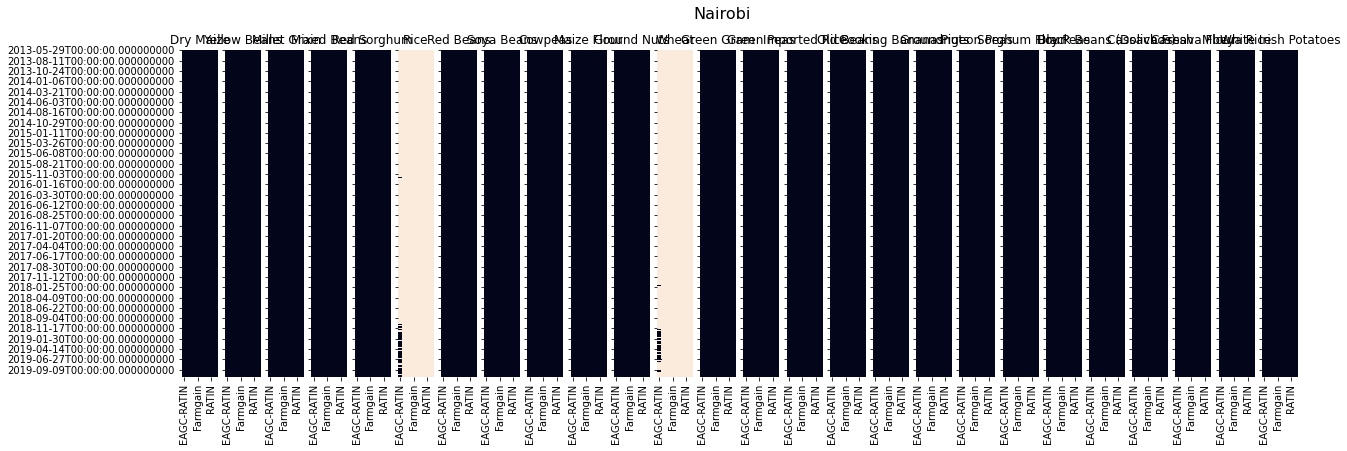

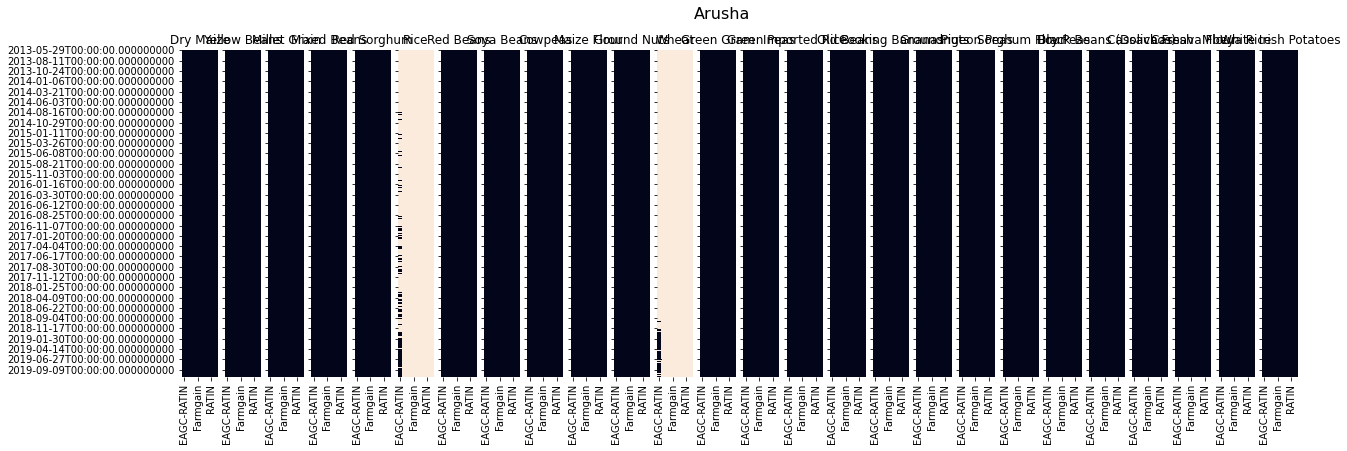

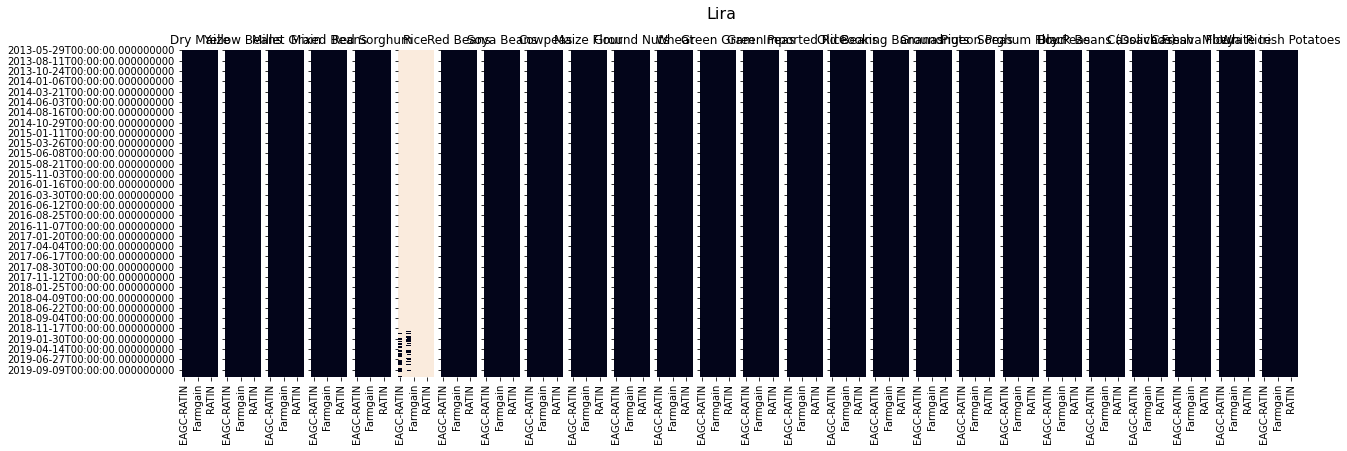

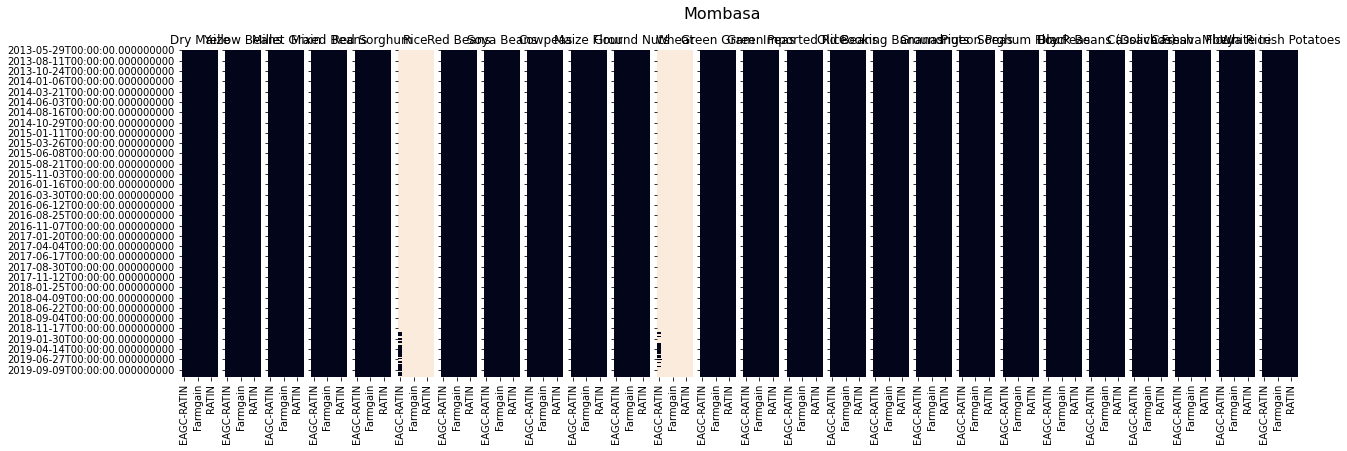

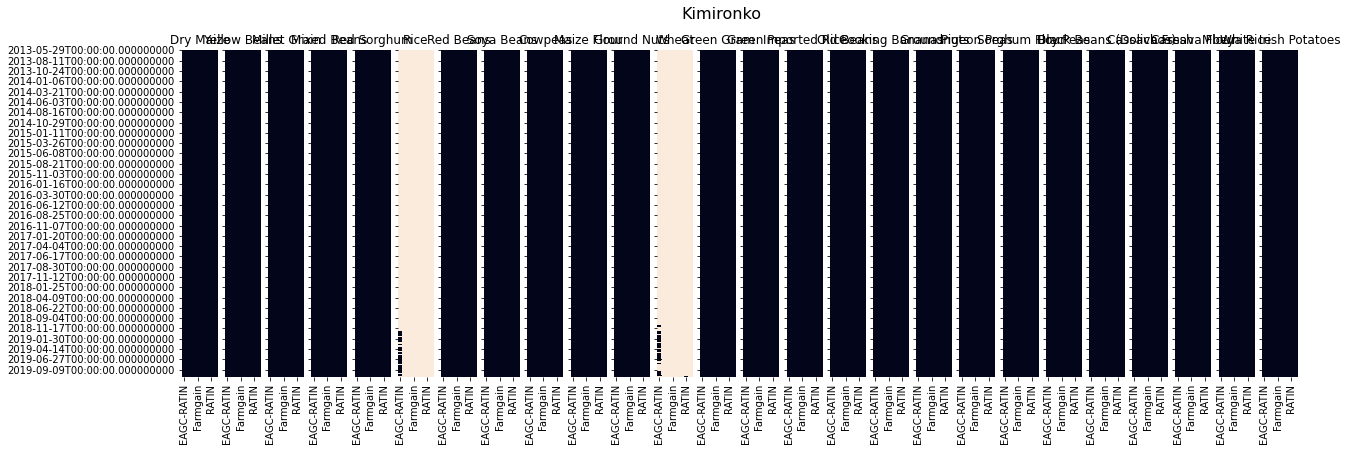

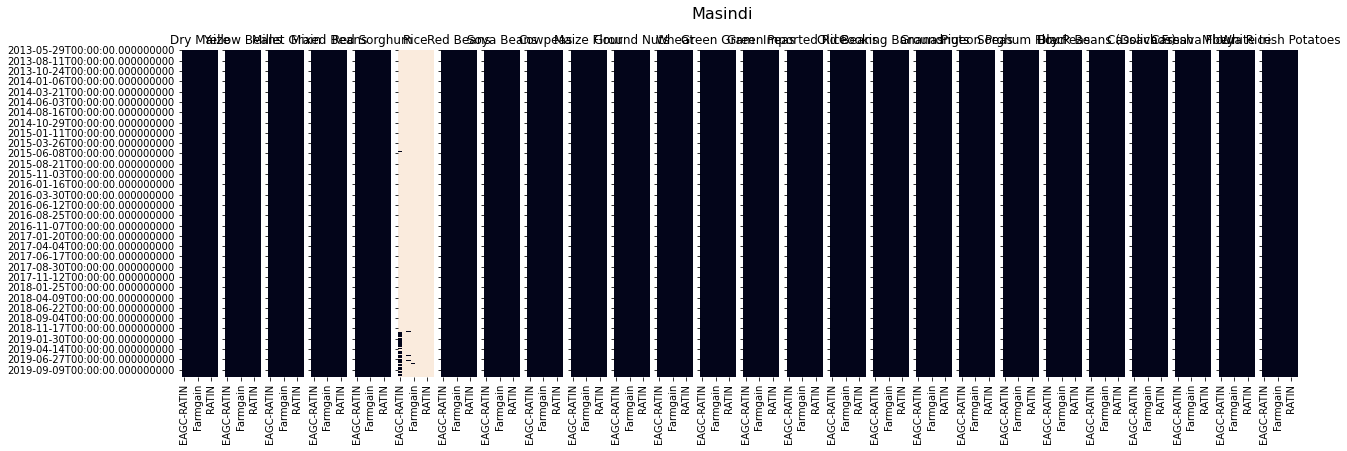

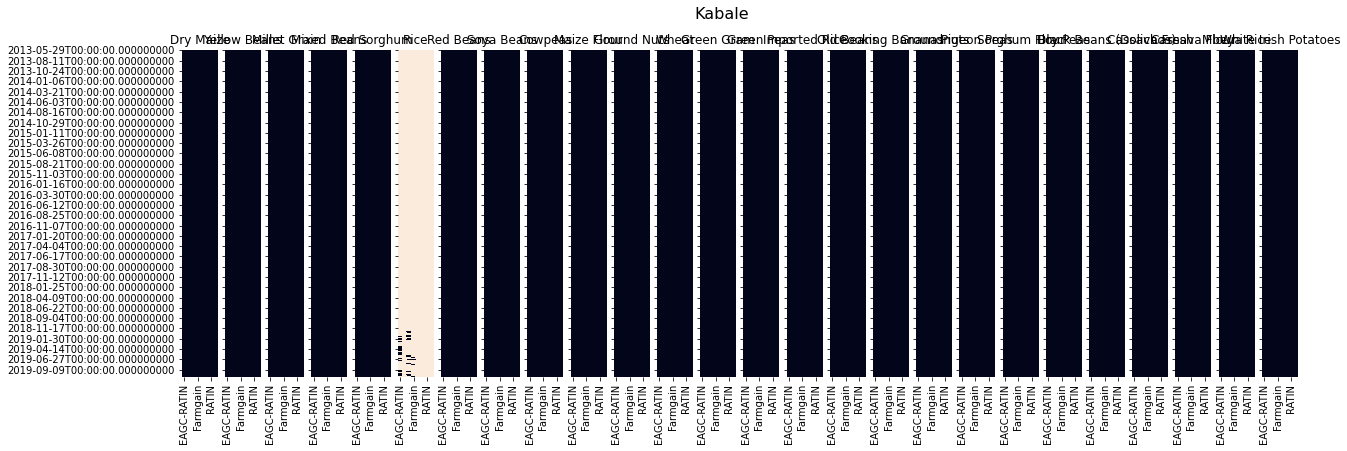

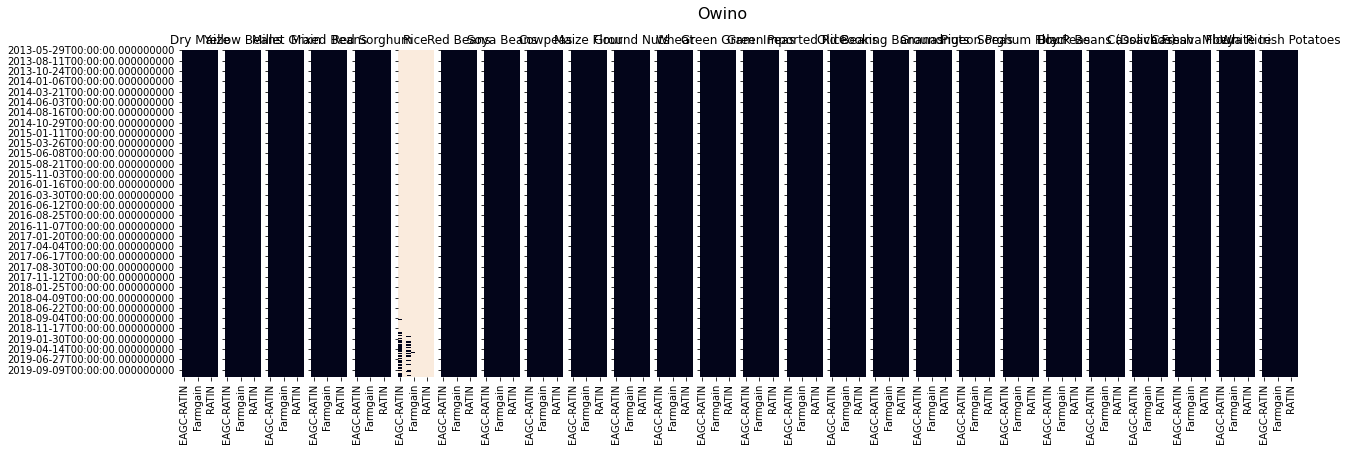

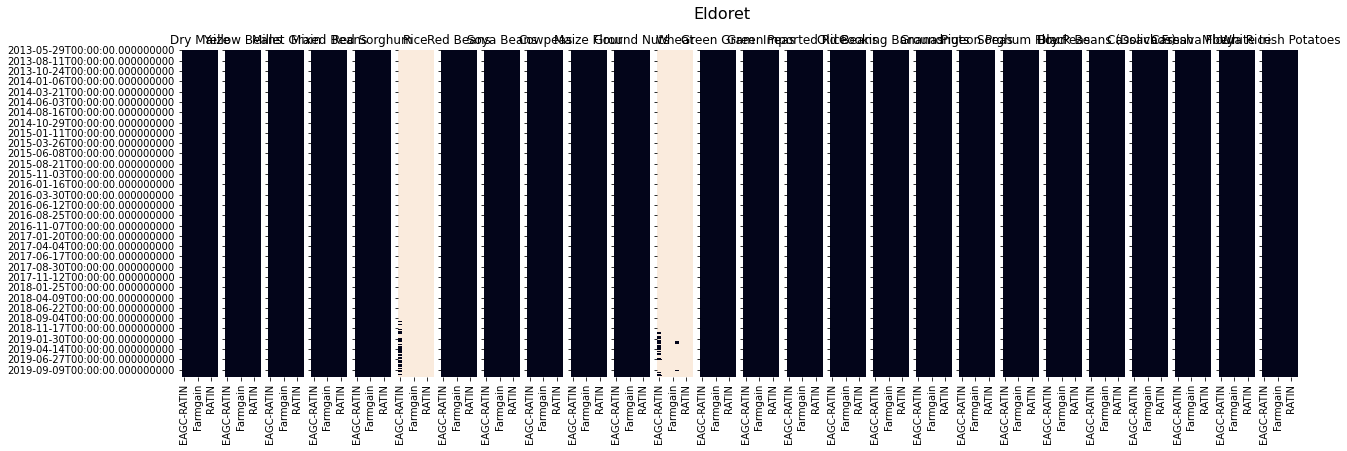

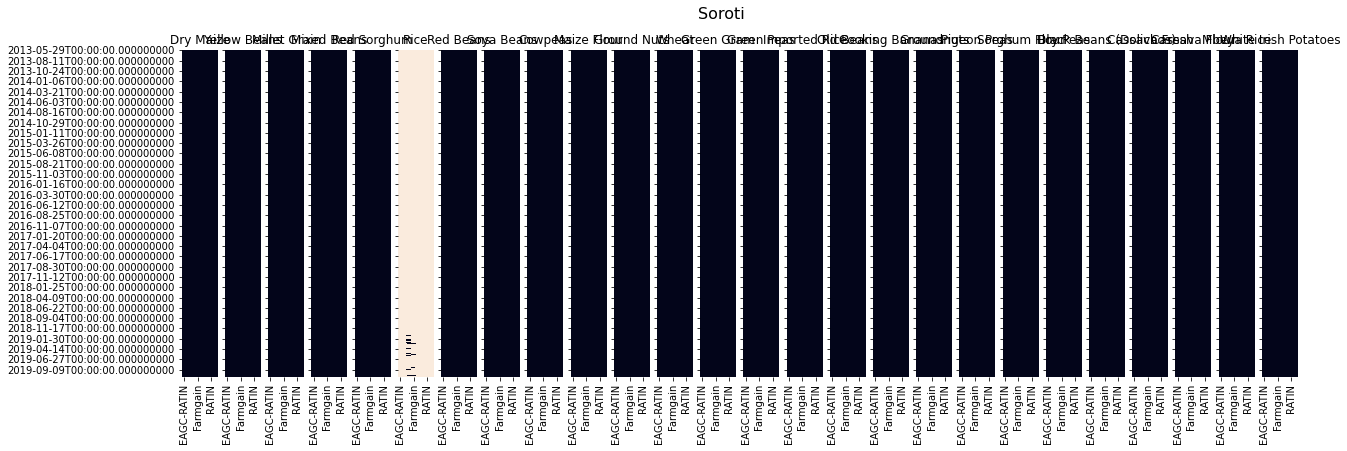

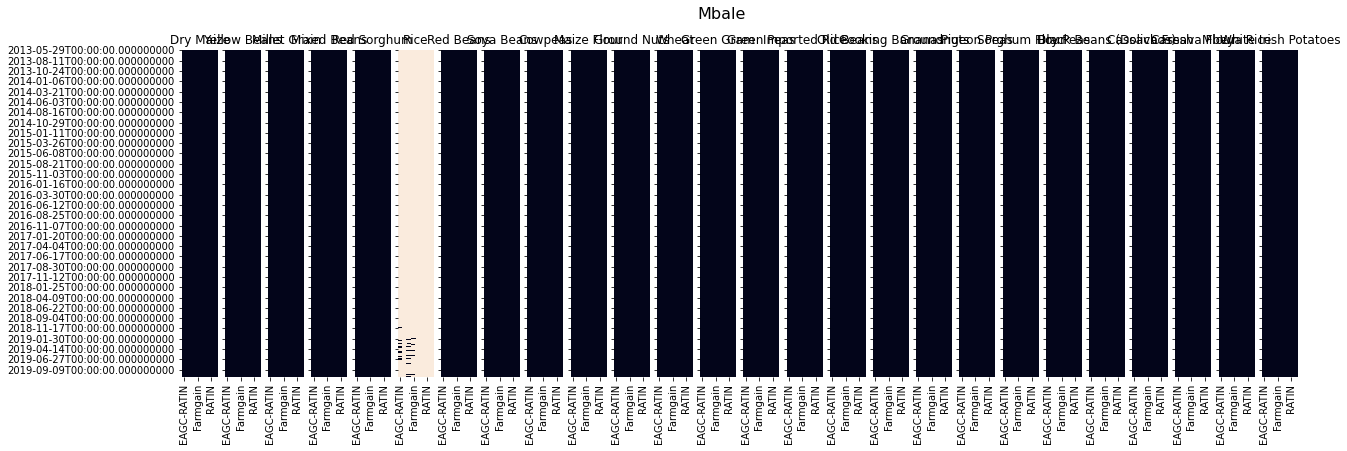

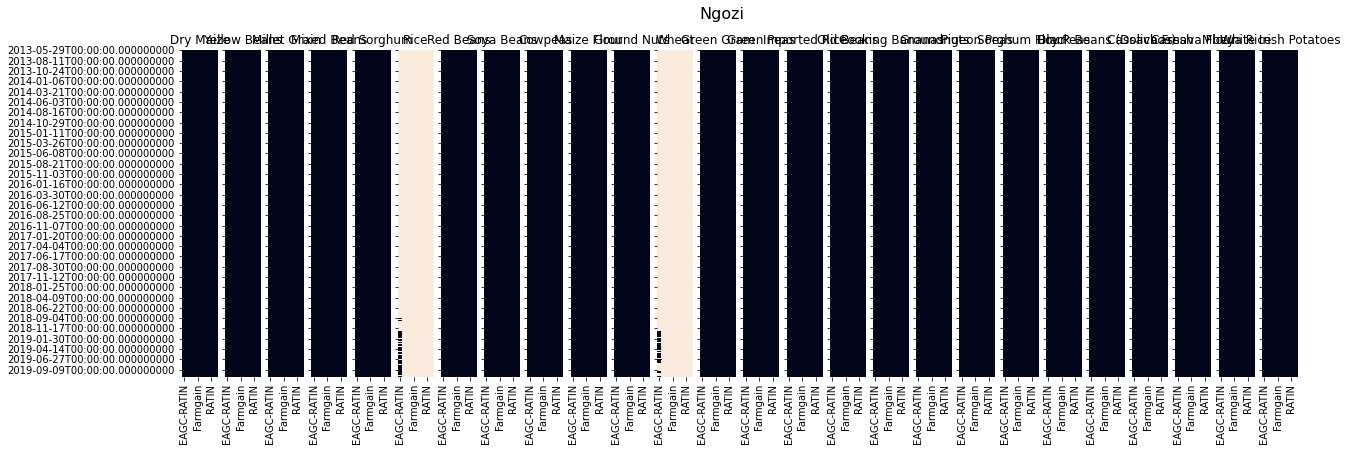

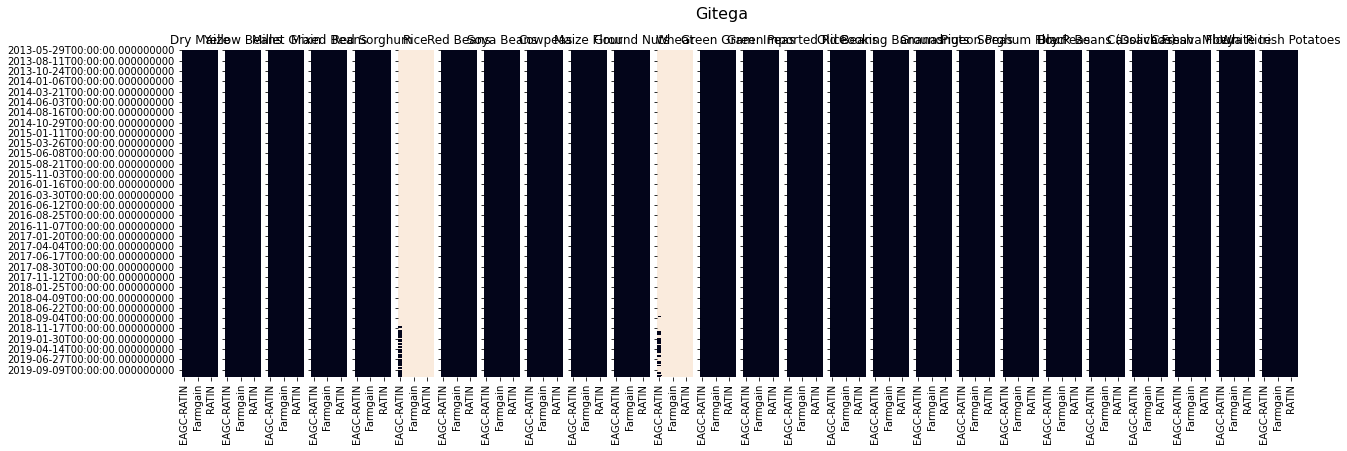

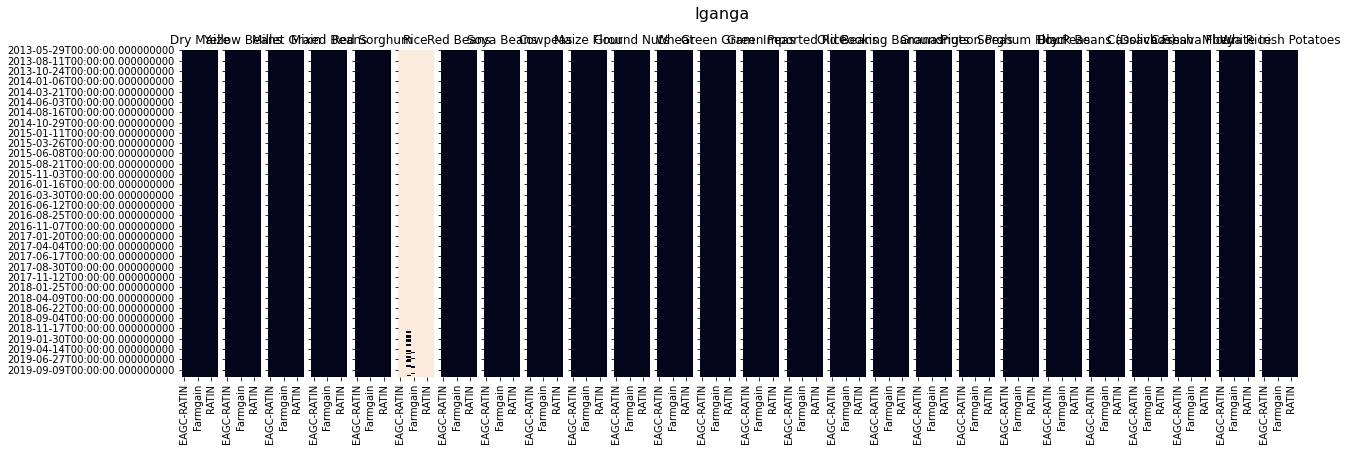

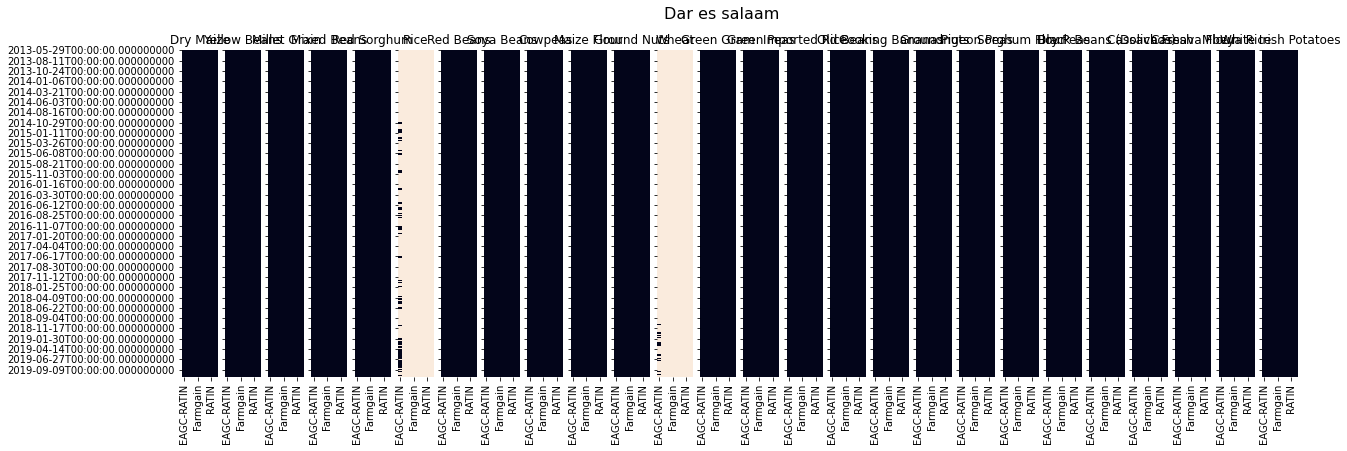

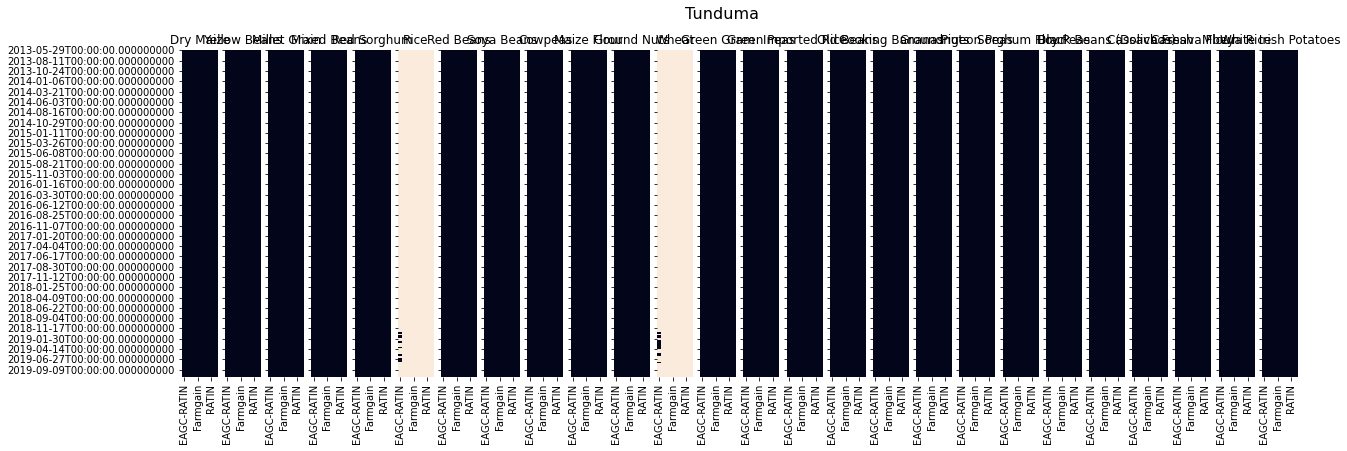

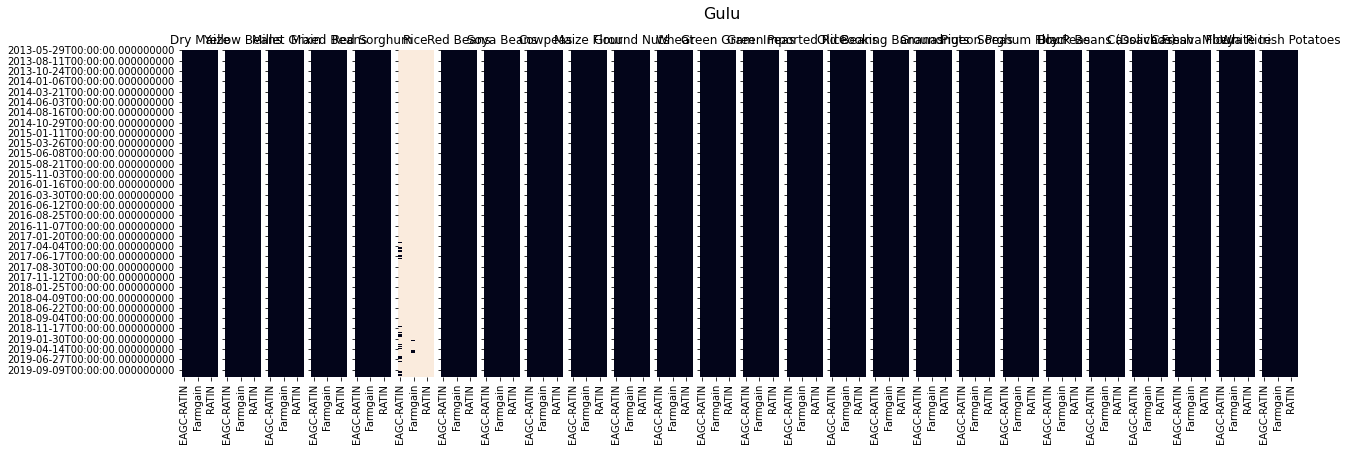

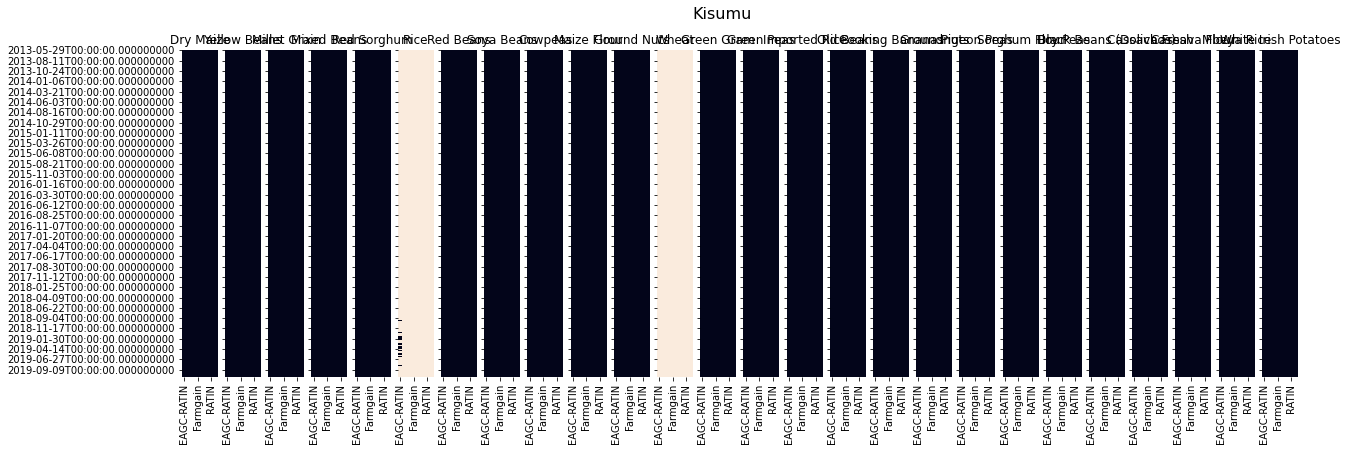

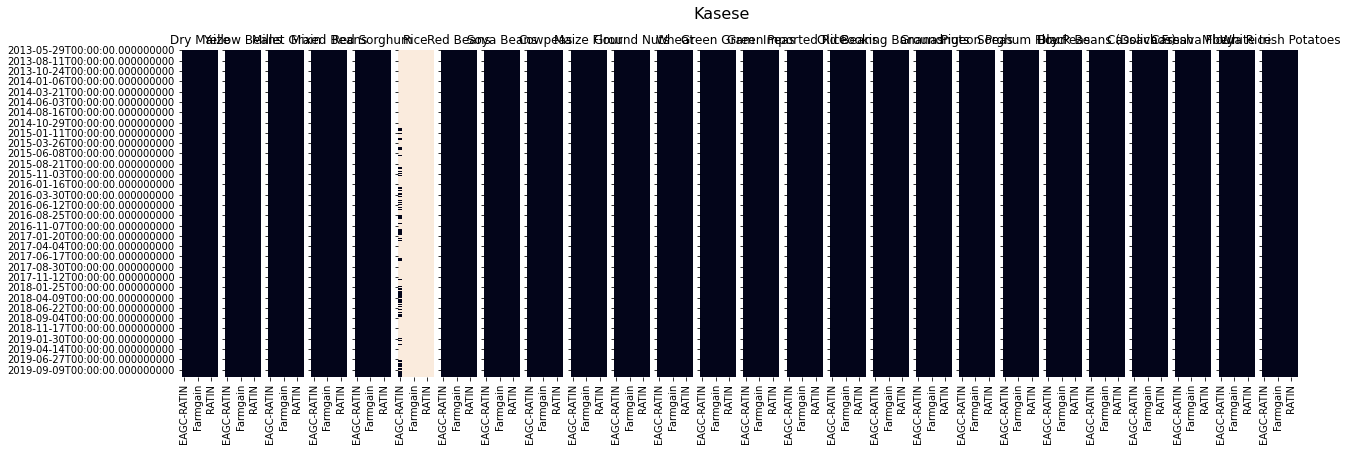

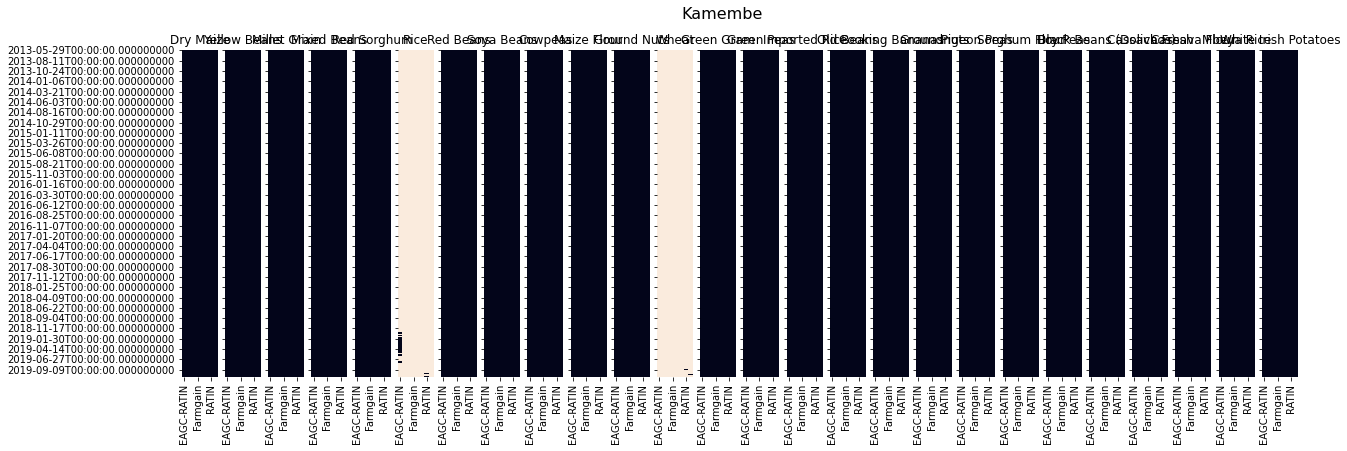

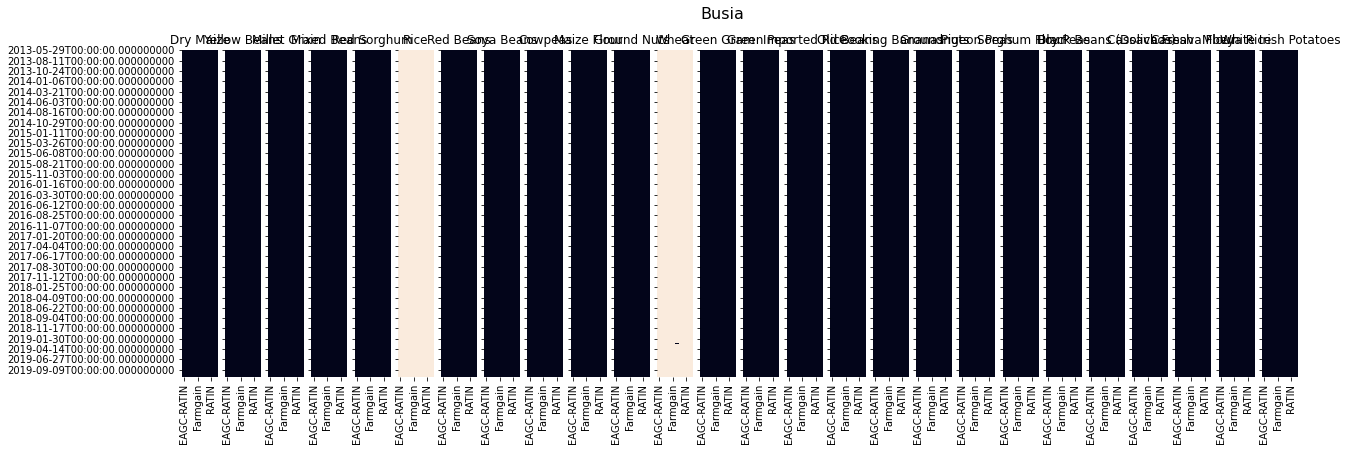

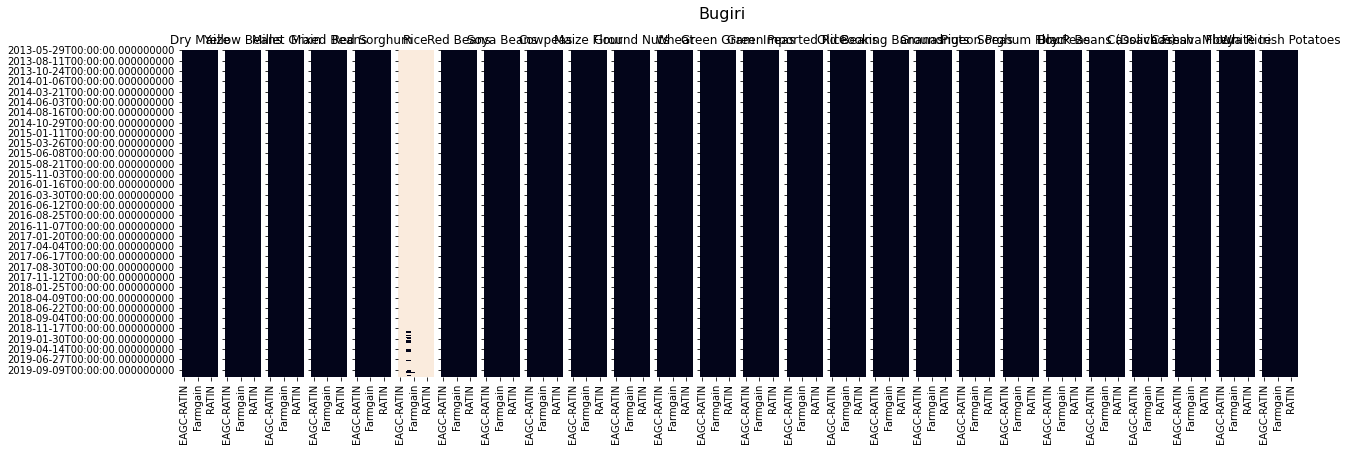

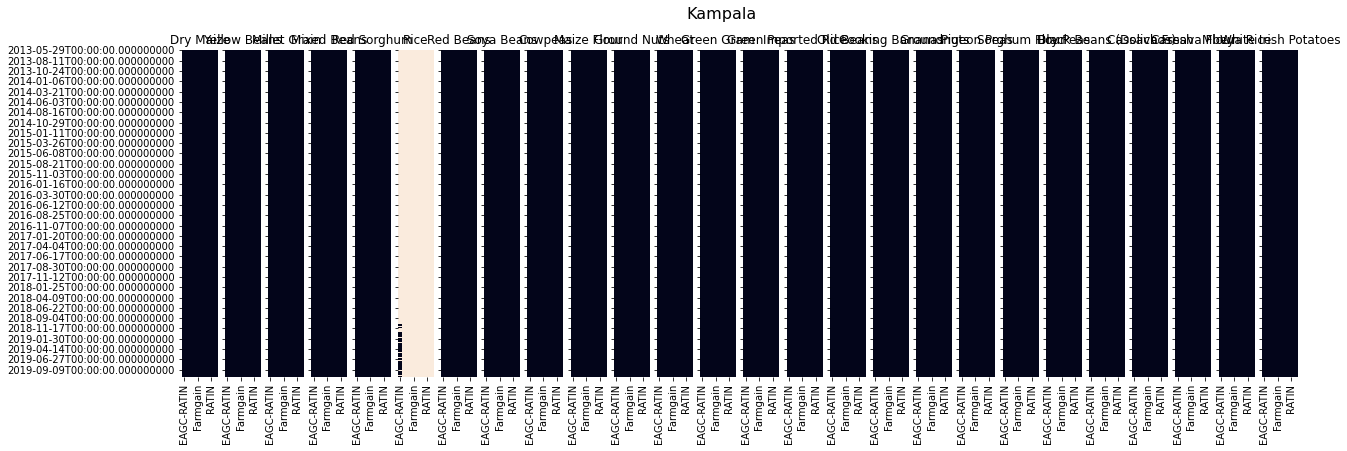

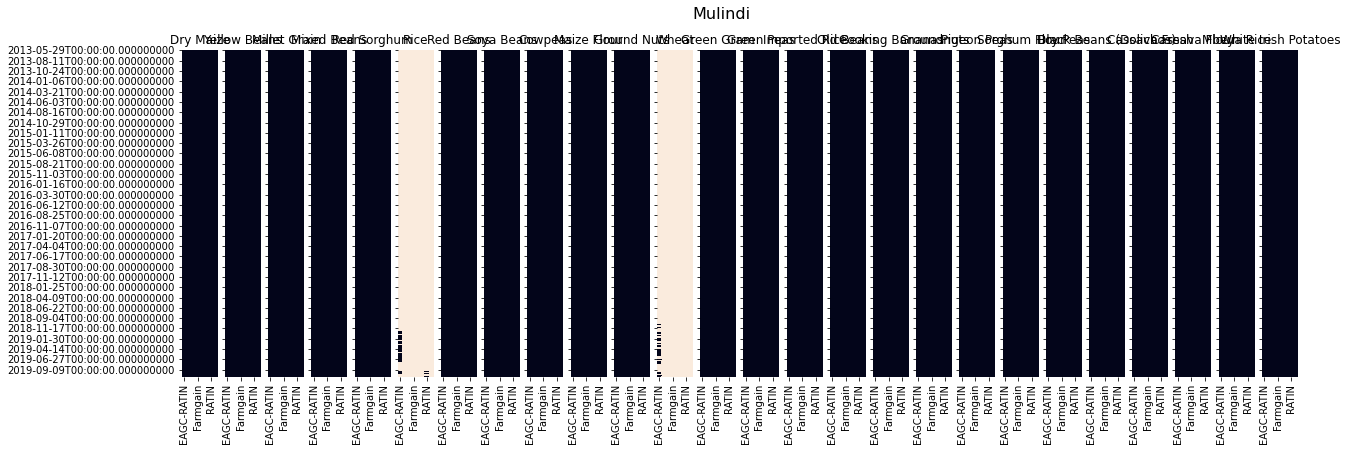

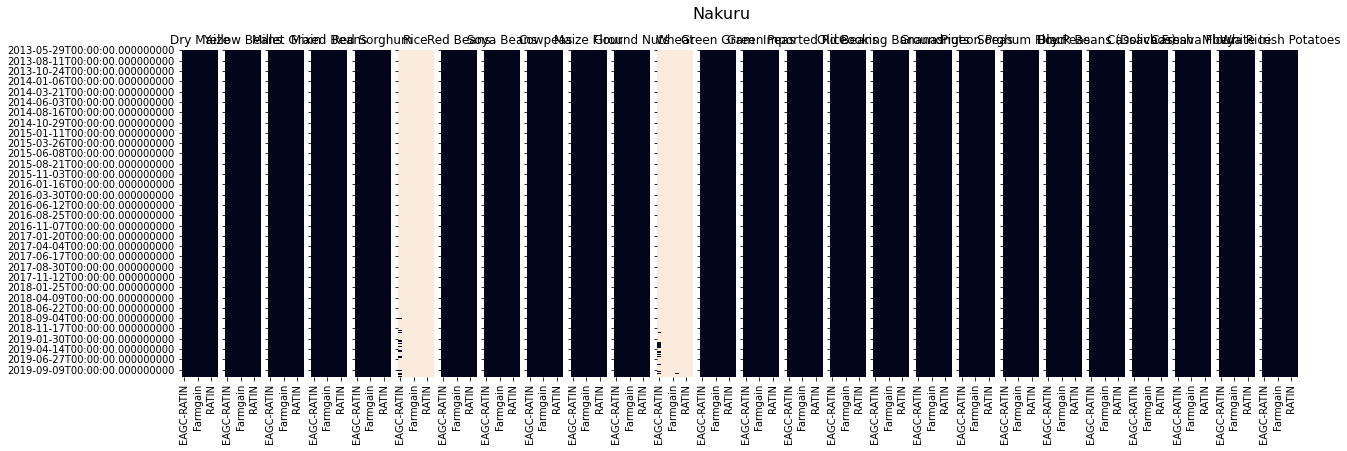

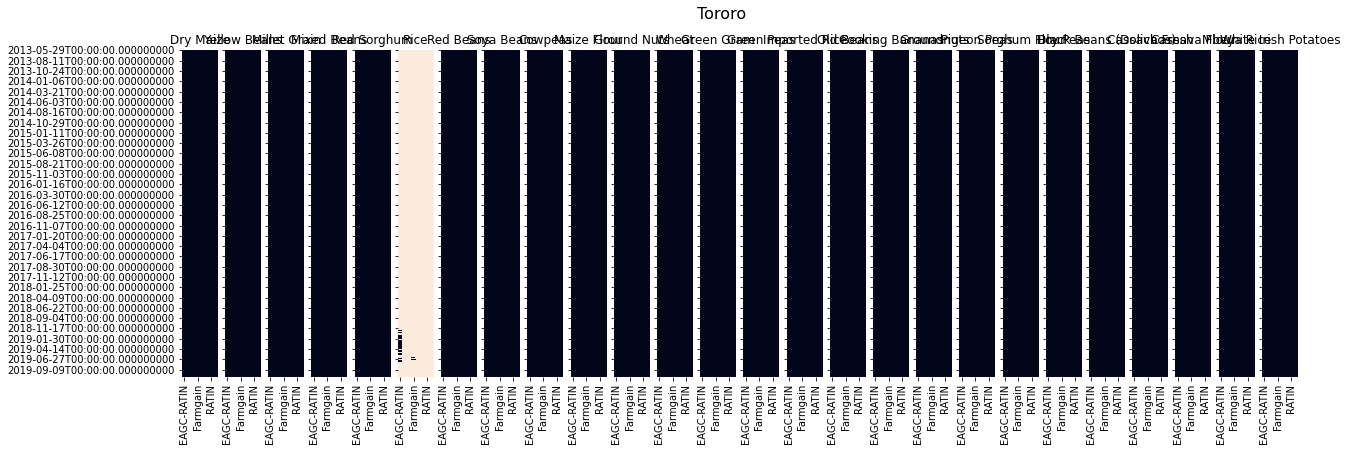

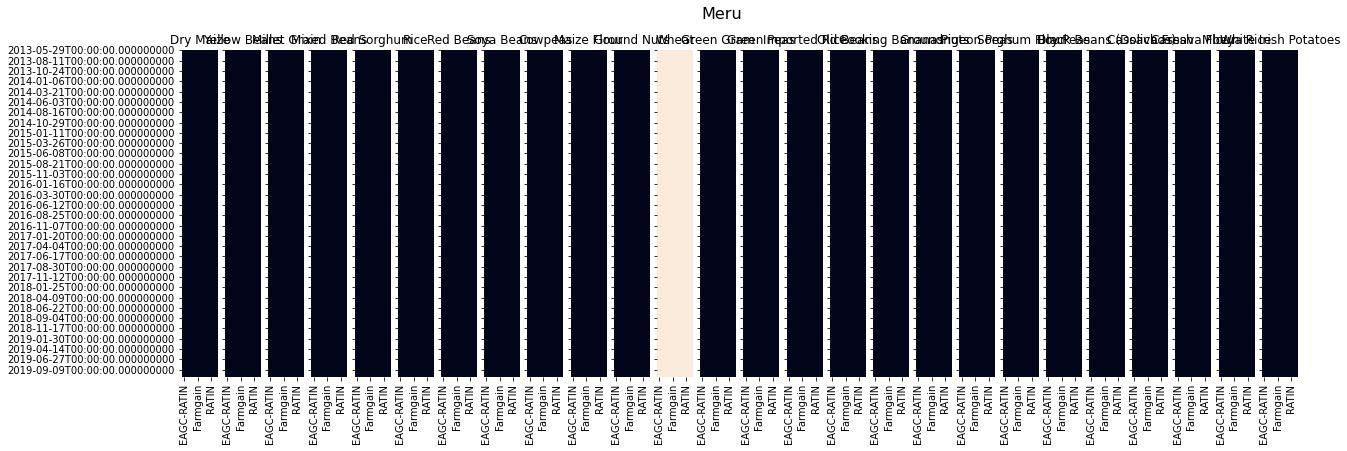

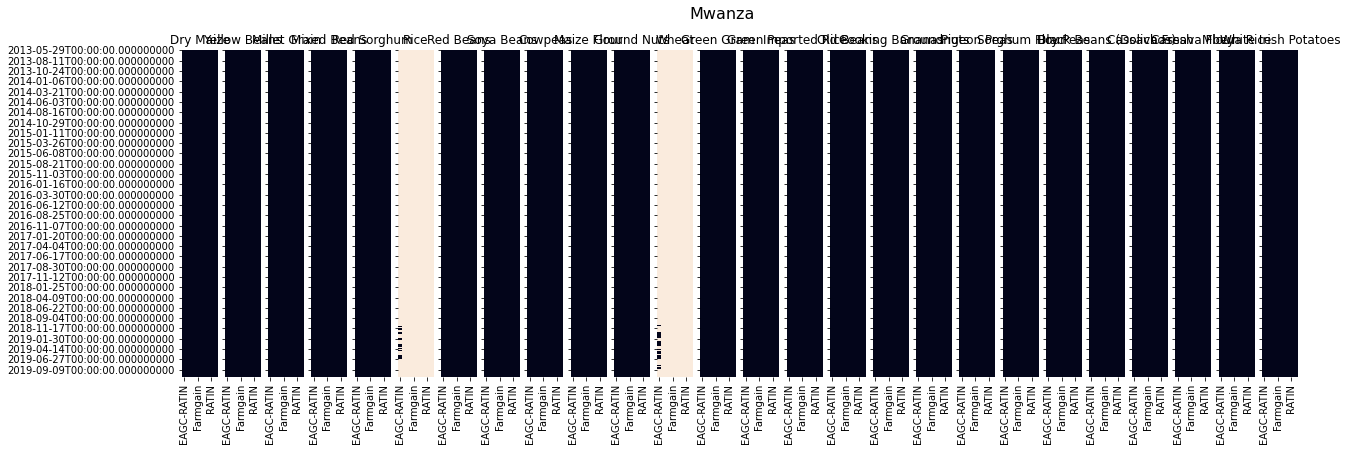

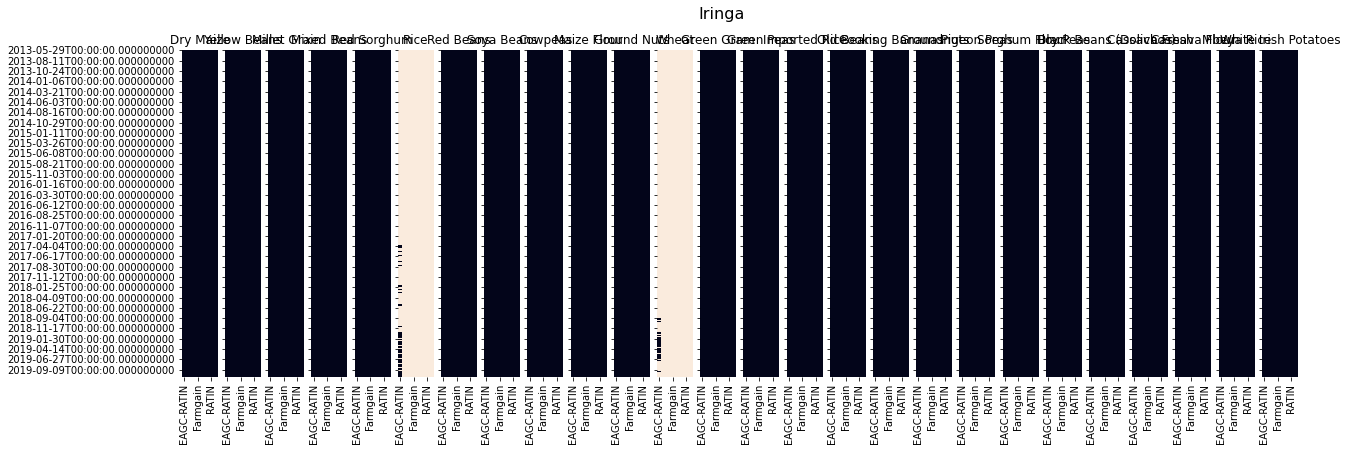

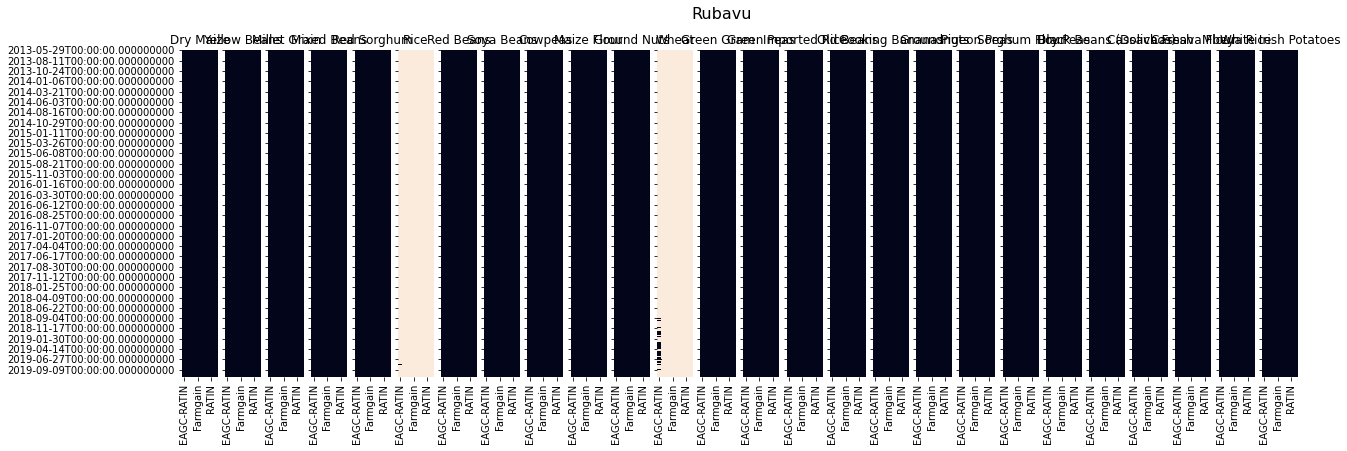

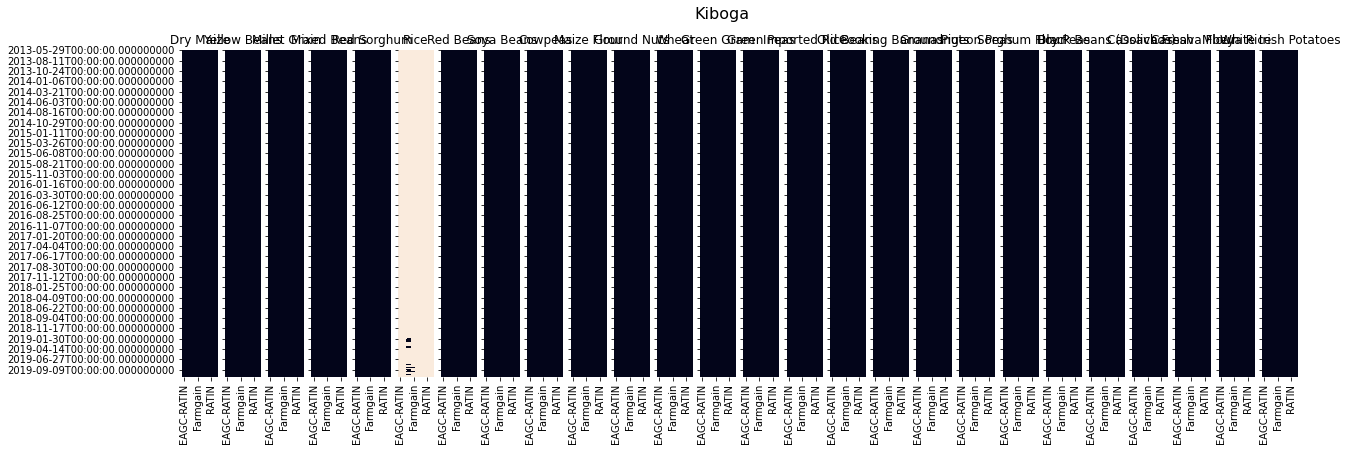

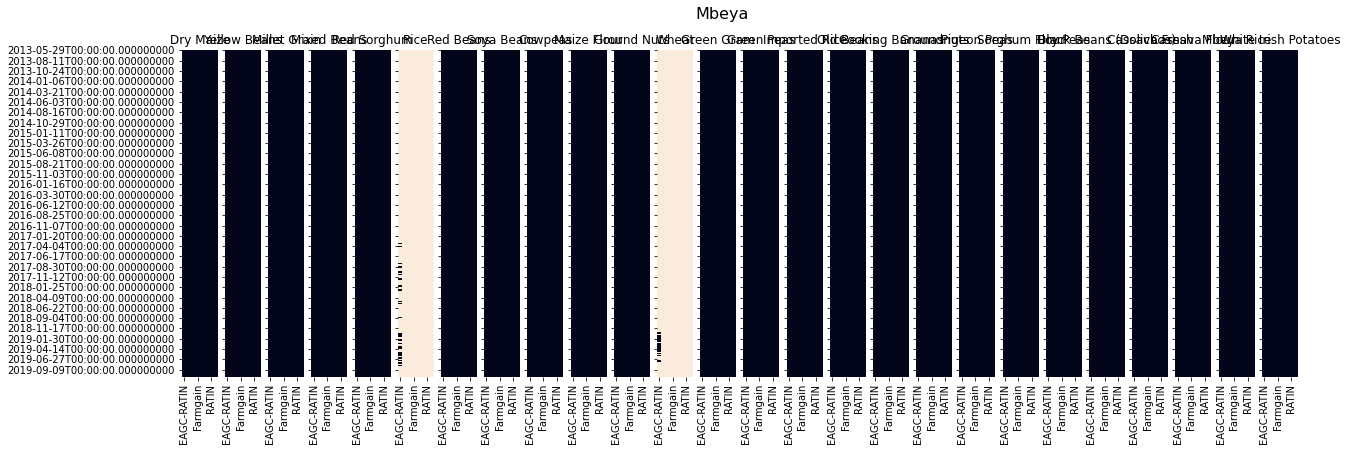

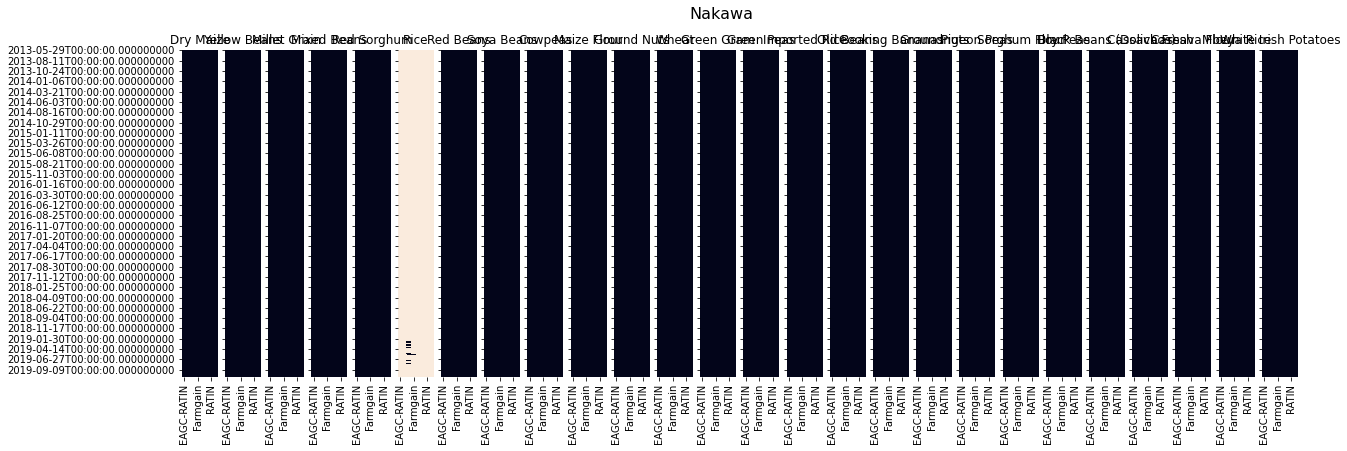

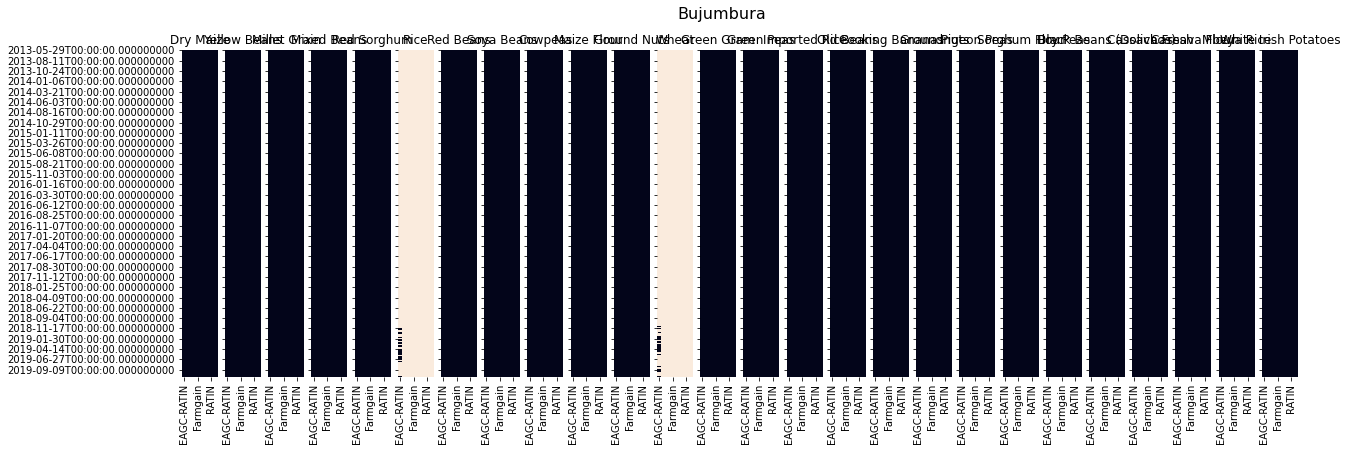

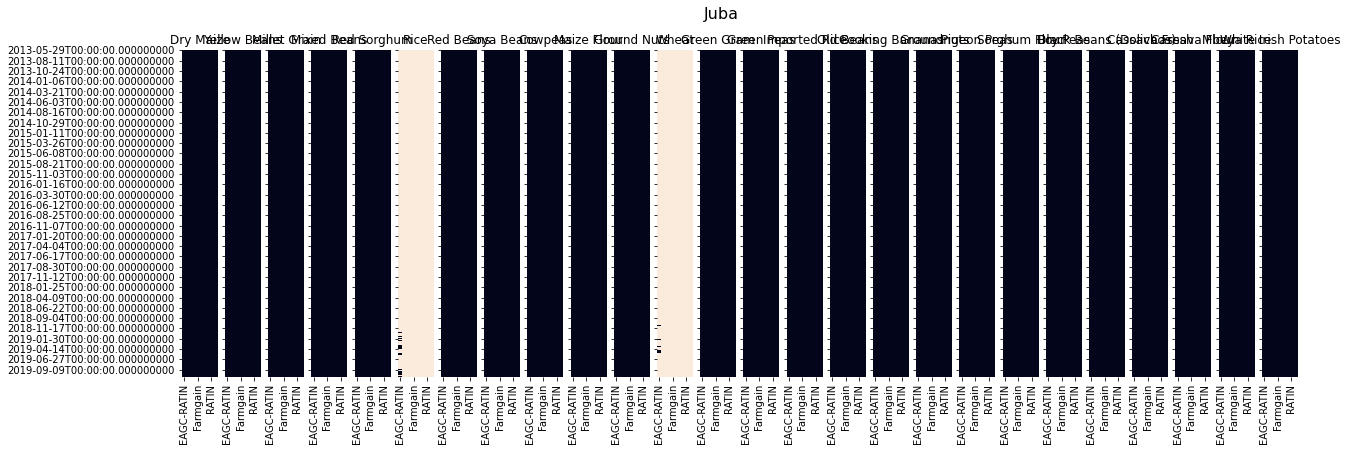

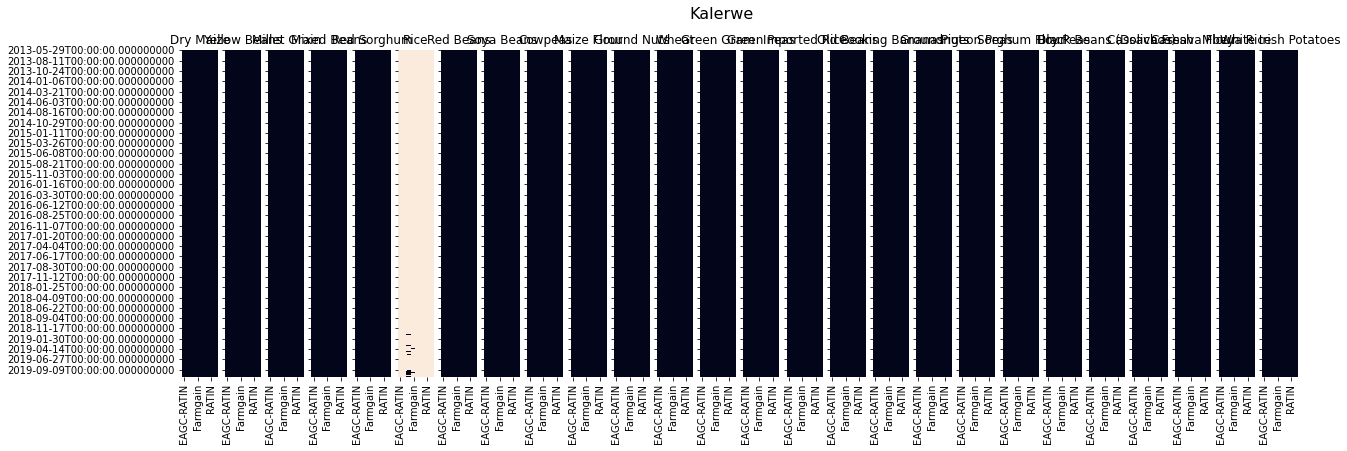

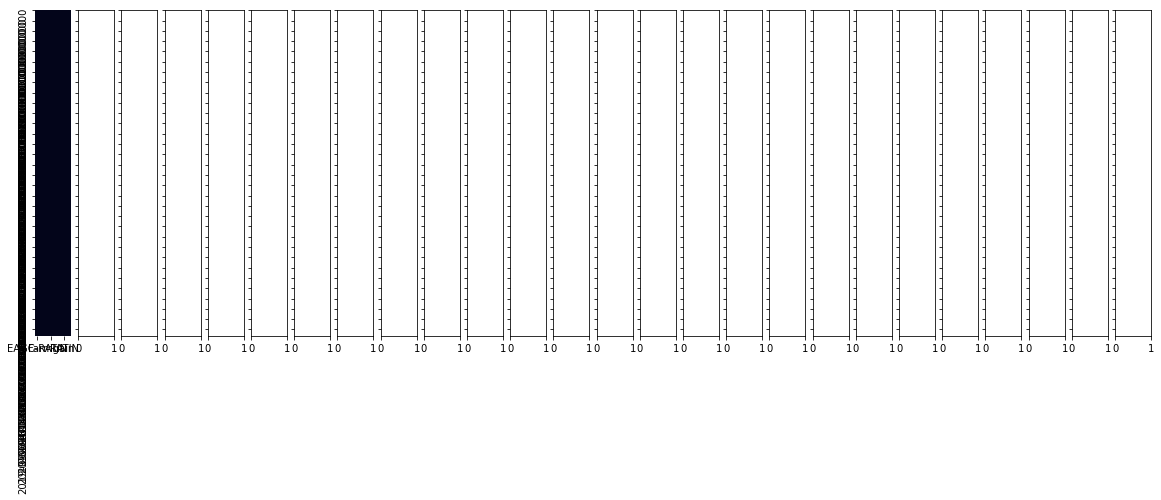

In [16]:
# Generate data completeness overview

date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
time_df = pd.DataFrame([], index=date_range)

N_plots = len(PRODUCT_LIST)
for MARKET in MARKET_LIST:
    fig, axs = plt.subplots(1, N_plots, sharey=True, figsize=(20,6))

    for PRODUCT, axi in zip(PRODUCT_LIST, axs):
        new_set = time_df

        for SOURCE in SOURCE_LIST:

            subset = df[(df['product_agg']==PRODUCT) & (df['source']==SOURCE) & (df['market']==MARKET)].sort_values('date').set_index('date')
            new_set = new_set.merge(subset[['wholesale']], how='left', left_index=True, right_index=True)
            new_colname = SOURCE
            new_set = new_set.rename(columns={'wholesale':new_colname})

        sns.heatmap(new_set.isnull(), cbar=False, ax=axi)
        axi.set_title(PRODUCT, rotation=90)
    fig.suptitle(MARKET, fontsize=16)
    plt.show

KeyboardInterrupt: 

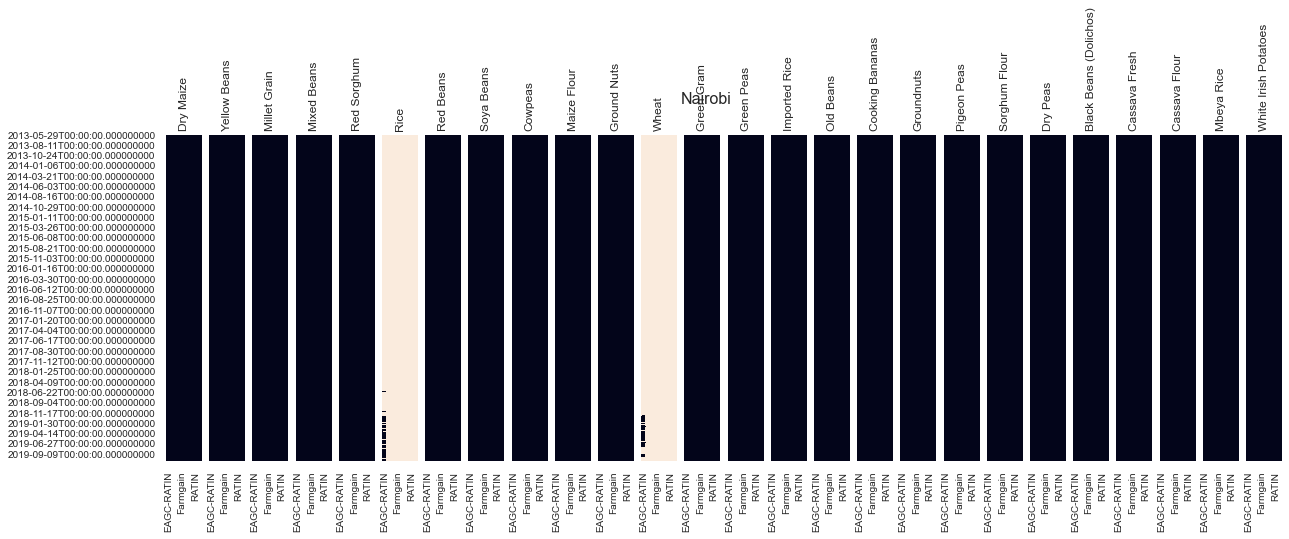

Error in callback <function flush_figures at 0x10f2b1c10> (for post_execute):


KeyboardInterrupt: 

In [40]:
# visulize data completeness overview

date_range = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')
time_df = pd.DataFrame([], index=date_range)

N_plots = len(PRODUCT_LIST)
for MARKET in MARKET_LIST:
    fig, axs = plt.subplots(1, N_plots, sharey=True, figsize=(20,6))

    for PRODUCT, axi in zip(PRODUCT_LIST, axs):
        new_set = time_df

        for SOURCE in SOURCE_LIST:

            subset = df[(df['product_agg']==PRODUCT) & (df['source']==SOURCE) & (df['market']==MARKET)].sort_values('date').set_index('date')
            new_set = new_set.merge(subset[['wholesale']], how='left', left_index=True, right_index=True)
            new_colname = SOURCE
            new_set = new_set.rename(columns={'wholesale':new_colname})

        sns.heatmap(new_set.isnull(), cbar=False, ax=axi)
        axi.set_title(PRODUCT, rotation=90)
    fig.suptitle(MARKET, fontsize=16)
    plt.show

In [ ]:
#missingno.matrix(new_set[['wholesale']])